# START


## Setup

In [31]:
!%pip install pandas numpy yfinance matplotlib seaborn ta scipy tqdm -q

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, ADXIndicator
from ta.volatility import AverageTrueRange, BollingerBands
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
import json

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ All imports successful!")

zsh:fg:1: no job control in this shell.
✅ All imports successful!


## Configuration and Data Classes

In [32]:
@dataclass
class StrategyConfig:
    """Strategy configuration parameters"""
    # --- Regime Parameters ---
    vix_smoothing_period: int = 10   # Smoothing window for VIX
    vix_low_threshold: float = 15.0  # VIX_MA level for "LOW_VOL"
    vix_high_threshold: float = 25.0 # VIX_MA level for "HIGH_VOL"
    
    # --- Calm Regime: Trend-Following ---
    ema_fast: int = 20
    ema_slow: int = 50
    
    # --- Panic Regime: Mean-Reversion ---
    bb_period: int = 20
    bb_std_dev: float = 2.0
    
    # --- Risk Management ---
    stop_loss_pct: float = 0.05 # 5%
    trailing_stop_pct: float = 0.03 # 3%
    
    # --- Portfolio Parameters ---
    initial_capital: float = 500000.0 # $500K
    transaction_cost: float = 0.001 # 0.1% transaction cost
    leverage: float = 0.0 # No leverage
    max_positions: int = 10 # Max concurrent positions
    
    # --- Data Parameters ---
    train_start: str = "2015-01-01"
    train_end: str = "2023-12-31"


class EventType(Enum):
    """Types of market events"""
    # Regime Switch Events (High Priority)
    REGIME_SWITCH_TO_CALM = "regime_switch_calm"
    REGIME_SWITCH_TO_PANIC = "regime_switch_panic"

    # Calm Regime Events (Trend)
    GOLDEN_CROSS = "golden_cross" # Long Entry, Short Exit
    DEATH_CROSS = "death_cross"   # Short Entry, Long Exit

    # Panic Regime Events (Mean-Reversion)
    PRICE_BELOW_LBB = "price_below_lbb" # Long Entry
    PRICE_ABOVE_UBB = "price_above_ubb" # Short Entry
    PRICE_TOUCH_MBB = "price_touch_mbb" # Long/Short Exit

    # Risk Events
    STOP_LOSS_HIT = "stop_loss_hit"
    TRAILING_STOP_HIT = "trailing_stop_hit"


@dataclass
class Event:
    """Represents a market event"""
    timestamp: datetime
    event_type: EventType
    symbol: str # 'GLOBAL' for regime events
    data: Dict
    priority: int = 0
    
    def __repr__(self):
        return f"Event({self.timestamp.date()}, {self.symbol}, {self.event_type.value}, p={self.priority})"


@dataclass
class Position:
    """Represents an open position"""
    symbol: str
    side: str # 'LONG' or 'SHORT'
    entry_price: float
    entry_time: datetime
    shares: float
    stop_loss: float
    trailing_stop: float
    # Track peak/trough for trailing stops
    highest_price: float = 0.0
    lowest_price: float = float('inf')
    
    @property
    def value(self) -> float:
        """Current position value"""
        return self.shares * self.entry_price


@dataclass
class Trade:
    """Completed trade record"""
    symbol: str
    side: str
    entry_time: datetime
    exit_time: datetime
    entry_price: float
    exit_price: float
    shares: float
    pnl: float
    pnl_pct: float
    reason: str


print("✅ Configuration and data classes defined!")

✅ Configuration and data classes defined!


## Data Preparation

In [33]:
def get_target_stocks() -> List[str]:
    """
    Get the target asset list
    """
    target_stocks = [
        'NVDA', 'AAPL', 'MSFT', 'AMZN', 'META', 'AVGO', 
        'GOOGL', 'TSLA', 'GOOG', 'BRK-B'
    ]
    benchmark = 'SPY' # Benchmark
    vix = '^VIX' # Regime signal
    
    return target_stocks, benchmark, vix

TARGET_STOCKS, BENCHMARK, VIX_TICKER = get_target_stocks()
print(f"✅ Using {len(TARGET_STOCKS)} target stocks: {', '.join(TARGET_STOCKS)}")
print(f"✅ Benchmark: {BENCHMARK}")
print(f"✅ Regime Signal: {VIX_TICKER}")

def load_vix_data(config: StrategyConfig) -> pd.DataFrame:
    """
    Load and process VIX data for regime detection
    Returns DataFrame with VIX data and regime indicators
    """
    print("Loading and processing VIX data for regime...")
    # Download VIX data
    vix = yf.Ticker("^VIX").history(start=config.train_start,
                                    end=config.train_end)
    
    if vix.empty:
        print(" CRITICAL ERROR: VIX data download failed.")
        return pd.DataFrame()

    # Strip timezone information to make it compatible with stock data
    vix.index = vix.index.tz_localize(None)
    
    # Ensure the index is unique.
    if not vix.index.is_unique:
        print("⚠️ Warning: VIX data contains duplicate index dates. Keeping first entry for each date.")
        vix = vix[~vix.index.duplicated(keep='first')]
        
    # Calculate smoothed VIX (simple moving average)
    vix['VIX_MA'] = vix['Close'].rolling(window=config.vix_smoothing_period).mean()
    
    # Define market regime
    vix['Regime'] = 'NORMAL' # Default
    vix.loc[vix['VIX_MA'] <= config.vix_low_threshold, 'Regime'] = 'LOW_VOL'
    vix.loc[vix['VIX_MA'] >= config.vix_high_threshold, 'Regime'] = 'HIGH_VOL'
    
    # Drop NaN values from moving average calculation
    vix = vix.dropna(subset=['VIX_MA', 'Regime'])
    
    print(f"✅ VIX data loaded. Regimes: {vix['Regime'].value_counts().to_dict()}")
    # Return only the columns we need to merge
    return vix[['VIX_MA', 'Regime']]

def calculate_indicators(df: pd.DataFrame, config: StrategyConfig) -> pd.DataFrame:
    """
    Calculate all required technical indicators.
    Assumes 'Regime' column is already merged into df
    """
    data = pd.DataFrame(index=df.index)
    data['Close'] = df['Close']
    data['High'] = df['High']
    data['Low'] = df['Low']
    data['Volume'] = df['Volume']
    
    # --- Regime Signal ---
    # Regime is pre-calculated and merged in
    data['Regime'] = df['Regime'] 
    
    # --- Calm Regime Indicators (Trend) ---
    data['EMA_Fast'] = EMAIndicator(df['Close'], window=config.ema_fast, fillna=True).ema_indicator()
    data['EMA_Slow'] = EMAIndicator(df['Close'], window=config.ema_slow, fillna=True).ema_indicator()
    
    # --- Panic Regime Indicators (Mean-Reversion) ---
    bb = BollingerBands(df['Close'], window=config.bb_period, window_dev=config.bb_std_dev, fillna=True)
    data['BB_H'] = bb.bollinger_hband() # Upper Band
    data['BB_M'] = bb.bollinger_mavg() # Middle Band
    data['BB_L'] = bb.bollinger_lband() # Lower Band
    
    # Drop initial NaN rows
    max_window = max(config.ema_slow, config.bb_period)
    data = data.iloc[max_window:]
    
    return data

print("✅ Technical indicators function defined!")

✅ Using 10 target stocks: NVDA, AAPL, MSFT, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
✅ Benchmark: SPY
✅ Regime Signal: ^VIX
✅ Technical indicators function defined!


## Event Detector

In [34]:
class EventDetector:
    """Detects market events from price data"""
    def __init__(self, config: StrategyConfig):
        self.config = config

    def detect_events(self, symbol: str, current_data: pd.Series, prev_data: Optional[pd.Series]) -> List[Event]:
        """Detect all events for a symbol at current timestamp"""
        events = []
        if prev_data is None:
            return events
            
        timestamp = current_data.name
        
        # --- 1. Check for Regime Switch (Highest Priority) ---
        current_regime = current_data['Regime']
        prev_regime = prev_data['Regime']
        
        if current_regime != prev_regime:
            event_type = None
            # Switch to Panic
            if current_regime == 'HIGH_VOL':
                event_type = EventType.REGIME_SWITCH_TO_PANIC
            # Switch to Calm
            elif current_regime in ['LOW_VOL', 'NORMAL']:
                event_type = EventType.REGIME_SWITCH_TO_CALM
            
            if event_type:
                events.append(Event(
                    timestamp=timestamp,
                    event_type=event_type,
                    symbol="GLOBAL", # Global event
                    data={'regime': current_regime},
                    priority=100 # Highest priority
                ))

        # --- 2. Check for Strategy-Specific Events based on *current* regime ---
        
        if current_regime in ['LOW_VOL', 'NORMAL']:
            # --- Calm Regime: Trend-Following (EMA Cross) ---
            # Golden Cross (Long Entry / Short Exit)
            if (current_data['EMA_Fast'] > current_data['EMA_Slow'] and
                prev_data['EMA_Fast'] <= prev_data['EMA_Slow']):
                events.append(Event(
                    timestamp=timestamp,
                    event_type=EventType.GOLDEN_CROSS,
                    symbol=symbol,
                    data={'price': current_data['Close']},
                    priority=10
                ))
            # Death Cross (Short Entry / Long Exit)
            if (current_data['EMA_Fast'] < current_data['EMA_Slow'] and
                prev_data['EMA_Fast'] >= prev_data['EMA_Slow']):
                events.append(Event(
                    timestamp=timestamp,
                    event_type=EventType.DEATH_CROSS,
                    symbol=symbol,
                    data={'price': current_data['Close']},
                    priority=10
                ))
                
        elif current_regime == 'HIGH_VOL':
            # --- Panic Regime: Mean-Reversion (Bollinger Bands) ---
            # Price crosses BELOW Lower Band (Long Entry)
            if (current_data['Close'] < current_data['BB_L'] and
                prev_data['Close'] >= prev_data['BB_L']):
                events.append(Event(
                    timestamp=timestamp,
                    event_type=EventType.PRICE_BELOW_LBB,
                    symbol=symbol,
                    data={'price': current_data['Close']},
                    priority=10
                ))
            # Price crosses ABOVE Upper Band (Short Entry)
            if (current_data['Close'] > current_data['BB_H'] and
                prev_data['Close'] <= prev_data['BB_H']):
                events.append(Event(
                    timestamp=timestamp,
                    event_type=EventType.PRICE_ABOVE_UBB,
                    symbol=symbol,
                    data={'price': current_data['Close']},
                    priority=10
                ))
            # Price touches Middle Band (Exit Signal)
            # Long Exit: Price crosses ABOVE middle band from below
            if (current_data['Close'] >= current_data['BB_M'] and
                prev_data['Close'] < current_data['BB_M']):
                events.append(Event(
                    timestamp=timestamp,
                    event_type=EventType.PRICE_TOUCH_MBB,
                    symbol=symbol,
                    data={'price': current_data['Close'], 'side_to_exit': 'LONG'},
                    priority=9 # Exit priority
                ))
            # Short Exit: Price crosses BELOW middle band from above
            if (current_data['Close'] <= current_data['BB_M'] and
                prev_data['Close'] > current_data['BB_M']):
                events.append(Event(
                    timestamp=timestamp,
                    event_type=EventType.PRICE_TOUCH_MBB,
                    symbol=symbol,
                    data={'price': current_data['Close'], 'side_to_exit': 'SHORT'},
                    priority=9 # Exit priority
                ))
                
        return events
print("✅ Event detector class defined!")

✅ Event detector class defined!


## Portfolio Backtester

In [49]:
class PortfolioBacktester:
    """
    Event-driven portfolio backtester for regime-switching
    """
    def __init__(self, config: StrategyConfig, stock_data: Dict[str, pd.DataFrame]):
        self.config = config
        self.stock_data = stock_data
        self.symbols = list(stock_data.keys())
        
        # --- Portfolio State ---
        self.capital = config.initial_capital
        self.initial_capital = config.initial_capital
        self.positions: Dict[str, Position] = {}
        self.trades: List[Trade] = []
        self.event_log: List[Event] = []
        
        # --- Regime State ---
        self.current_regime: str = 'CALM' # Initial assumption
        
        # --- Daily Tracking ---
        self.daily_capital: List[Dict] = []
        
        # --- Event Detection ---
        self.event_detector = EventDetector(config)
        self.previous_data: Dict[str, pd.Series] = {}
        
        # Get all unique dates
        all_dates = set()
        for df in stock_data.values():
            all_dates.update(df.index)
        self.trading_dates = sorted(list(all_dates))

    def calculate_position_size(self, price: float) -> float:
        """Calculate number of shares to buy/short"""
        # Use equal weight sizing based on max_positions
        # This is simpler and more robust for a multi-asset portfolio
        position_capital = (self.capital / self.config.max_positions)
        
        # Don't overallocate
        position_capital = min(position_capital, self.capital) 
        
        if position_capital <= 0:
            return 0
            
        shares = position_capital / price
        return shares

    def can_open_position(self) -> bool:
        """Check if we can open a new position"""
        return len(self.positions) < self.config.max_positions

    def open_position(self, symbol: str, side: str, price: float, timestamp: datetime):
        """Open a new long or short position"""
        if not self.can_open_position():
            return # Max positions reached
            
        shares = self.calculate_position_size(price)
        if shares == 0:
            return # Not enough capital
            
        position_cost = shares * price
        transaction_fee = position_cost * self.config.transaction_cost
        
        if side == 'LONG':
            total_cost = position_cost + transaction_fee
            if total_cost > self.capital:
                return # Not enough capital
            self.capital -= total_cost
            stop_loss = price * (1 - self.config.stop_loss_pct)
            trailing_stop = price * (1 - self.config.trailing_stop_pct)
        
        elif side == 'SHORT':
            # Assuming margin account, cash impact is just the fee
            # The proceeds from the short sale are held as collateral
            # We receive cash from the short sale
            self.capital += (position_cost - transaction_fee)
            stop_loss = price * (1 + self.config.stop_loss_pct)
            trailing_stop = price * (1 + self.config.trailing_stop_pct)

        position = Position(
            symbol=symbol,
            side=side,
            entry_price=price,
            entry_time=timestamp,
            shares=shares,
            stop_loss=stop_loss,
            trailing_stop=trailing_stop,
            highest_price=price if side == 'LONG' else 0,
            lowest_price=price if side == 'SHORT' else float('inf')
        )
        self.positions[symbol] = position

    def close_position(self, symbol: str, price: float, timestamp: datetime, reason: str):
        """Close an existing position"""
        if symbol not in self.positions:
            return
            
        position = self.positions[symbol]
        position_value = position.shares * price
        transaction_fee = position_value * self.config.transaction_cost
        
        if position.side == 'LONG':
            proceeds = position_value - transaction_fee
            self.capital += proceeds
            pnl = (price - position.entry_price) * position.shares - transaction_fee
            pnl_pct = (price - position.entry_price) / position.entry_price
        
        elif position.side == 'SHORT':
            cost_to_close = position_value + transaction_fee
            self.capital -= cost_to_close # Pay to buy back shares
            pnl = (position.entry_price - price) * position.shares - transaction_fee
            pnl_pct = (position.entry_price - price) / position.entry_price

        # Record trade
        trade = Trade(
            symbol=symbol,
            side=position.side,
            entry_time=position.entry_time,
            exit_time=timestamp,
            entry_price=position.entry_price,
            exit_price=price,
            shares=position.shares,
            pnl=pnl,
            pnl_pct=pnl_pct,
            reason=reason
        )
        self.trades.append(trade)
        del self.positions[symbol]

    def close_all_positions(self, timestamp: datetime, reason: str):
        """Close all open positions immediately"""
        symbols_to_close = list(self.positions.keys())
        # print(f"--- {timestamp.date()}: {reason} --- Closing {len(symbols_to_close)} positions.")
        for symbol in symbols_to_close:
            # Get the current price to close
            if timestamp in self.stock_data[symbol].index:
                current_price = self.stock_data[symbol].loc[timestamp, 'Close']
                self.close_position(symbol, current_price, timestamp, reason)

    def check_stops(self, symbol: str, current_price: float, timestamp: datetime):
        """Check if stops are hit for a position"""
        if symbol not in self.positions:
            return
            
        position = self.positions[symbol]
        
        if position.side == 'LONG':
            # Update highest price and trailing stop
            if current_price > position.highest_price:
                position.highest_price = current_price
                position.trailing_stop = current_price * (1 - self.config.trailing_stop_pct)
            
            # Check stop loss
            if current_price <= position.stop_loss:
                self.close_position(symbol, current_price, timestamp, "Stop Loss")
            # Check trailing stop
            elif current_price <= position.trailing_stop:
                self.close_position(symbol, current_price, timestamp, "Trailing Stop")
        
        elif position.side == 'SHORT':
            # Update lowest price and trailing stop
            if current_price < position.lowest_price:
                position.lowest_price = current_price
                position.trailing_stop = current_price * (1 + self.config.trailing_stop_pct)

            # Check stop loss
            if current_price >= position.stop_loss:
                self.close_position(symbol, current_price, timestamp, "Stop Loss")
            # Check trailing stop
            elif current_price >= position.trailing_stop:
                self.close_position(symbol, current_price, timestamp, "Trailing Stop")


    def handle_event(self, event: Event):
        """Handle a market event"""
        self.event_log.append(event)
        symbol = event.symbol
        
        # --- 1. Handle Regime Switch (Highest Priority) ---
        if event.event_type == EventType.REGIME_SWITCH_TO_PANIC:
            self.current_regime = event.data['regime'] # Will be 'HIGH_VOL'
            self.close_all_positions(event.timestamp, f"Regime Switch to {self.current_regime}")
            return # Stop processing other events for this day
            
        if event.event_type == EventType.REGIME_SWITCH_TO_CALM:
            self.current_regime = event.data['regime'] # Will be 'LOW_VOL' or 'NORMAL'
            self.close_all_positions(event.timestamp, f"Regime Switch to {self.current_regime}")
            return # Stop processing other events for this day

        # --- 2. Handle Strategy Logic based on CURRENT regime ---
        
        if self.current_regime in ['LOW_VOL', 'NORMAL']:
            # --- Calm Logic: Trend ---
            if event.event_type == EventType.GOLDEN_CROSS:
                # Exit short if open
                if symbol in self.positions and self.positions[symbol].side == 'SHORT':
                    self.close_position(symbol, event.data['price'], event.timestamp, "Golden Cross (Exit Short)")
                # Enter long if no position
                if symbol not in self.positions and self.can_open_position():
                    self.open_position(symbol, 'LONG', event.data['price'], event.timestamp)

            elif event.event_type == EventType.DEATH_CROSS:
                # Exit long if open
                if symbol in self.positions and self.positions[symbol].side == 'LONG':
                    self.close_position(symbol, event.data['price'], event.timestamp, "Death Cross (Exit Long)")
                # Enter short if no position
                if symbol not in self.positions and self.can_open_position():
                    self.open_position(symbol, 'SHORT', event.data['price'], event.timestamp)

        elif self.current_regime == 'HIGH_VOL':
            # --- Panic Logic: Mean-Reversion ---
            if event.event_type == EventType.PRICE_BELOW_LBB:
                # Enter long if no position
                if symbol not in self.positions and self.can_open_position():
                    self.open_position(symbol, 'LONG', event.data['price'], event.timestamp)
            
            elif event.event_type == EventType.PRICE_ABOVE_UBB:
                # Enter short if no position
                if symbol not in self.positions and self.can_open_position():
                    self.open_position(symbol, 'SHORT', event.data['price'], event.timestamp)

            elif event.event_type == EventType.PRICE_TOUCH_MBB:
                # Exit if position matches
                if (symbol in self.positions and 
                    self.positions[symbol].side == event.data['side_to_exit']):
                    self.close_position(symbol, event.data['price'], event.timestamp, "Mean Reversion (Hit MBB)")

    def calculate_portfolio_value(self, date: datetime) -> float:
        """Calculate total portfolio equity (cash + open positions) on a given date"""
        total_equity = self.capital # Start with free cash
        
        for symbol, position in self.positions.items():
            if date in self.stock_data[symbol].index:
                current_price = self.stock_data[symbol].loc[date, 'Close']
                
                if position.side == 'LONG':
                    # Add value of long asset
                    total_equity += position.shares * current_price
                
                elif position.side == 'SHORT':
                    # Add cash received from short, then add P&L
                    entry_value = position.shares * position.entry_price
                    current_value = position.shares * current_price
                    pnl = entry_value - current_value
                    total_equity += (entry_value + pnl) 
            else:
                # If date is missing, use last known values (less accurate)
                if position.side == 'LONG':
                    total_equity += position.shares * position.entry_price
                elif position.side == 'SHORT':
                    total_equity -= position.shares * position.entry_price # Cash from sale
                    
        return total_equity

    def run(self):
        """Run the backtest"""
        print(f"\n{'='*60}")
        print("EVENT-DRIVEN PORTFOLIO BACKTEST")
        print(f"{'='*60}")
        print(f"Period: {self.config.train_start} to {self.config.train_end}")
        print(f"Universe: {len(self.symbols)} stocks")
        print(f"Initial Capital: ${self.initial_capital:,.0f}")
        
        # Set initial regime
        first_date = self.trading_dates[0]
        self.current_regime = self.stock_data[self.symbols[0]].loc[first_date, 'Regime']
        print(f"Starting Regime: {self.current_regime}")
        print(f"{'='*60}\n")
        
        processed_regime_events = {} # To avoid double-counting global events

        # Process each trading day
        for date in tqdm(self.trading_dates, desc="Processing days"):
            day_events = []
            
            for symbol in self.symbols:
                if date not in self.stock_data[symbol].index:
                    continue
                
                current_data = self.stock_data[symbol].loc[date]
                prev_data = self.previous_data.get(symbol)
                
                # Detect events
                events = self.event_detector.detect_events(symbol, current_data, prev_data)
                
                # --- Handle Global Event ---
                for e in events:
                    if e.event_type in [EventType.REGIME_SWITCH_TO_CALM, EventType.REGIME_SWITCH_TO_PANIC]:
                        if date not in processed_regime_events:
                            day_events.append(e)
                            processed_regime_events[date] = True
                    else:
                        day_events.append(e)

                # Check stops
                self.check_stops(symbol, current_data['Close'], date)
                
                # Update previous data
                self.previous_data[symbol] = current_data
            
            # Sort events by priority (Regime switch will be first)
            day_events.sort(key=lambda e: e.priority, reverse=True)
            
            # Handle all events
            for event in day_events:
                self.handle_event(event)
                # If it was a regime switch, stop processing for the day
                if event.event_type in [EventType.REGIME_SWITCH_TO_CALM, EventType.REGIME_SWITCH_TO_PANIC]:
                    break

            # Calculate daily portfolio value
            portfolio_value = self.calculate_portfolio_value(date)
            self.daily_capital.append({
                'date': date,
                'capital': self.capital,
                'portfolio_value': portfolio_value,
                'num_positions': len(self.positions),
                'regime': self.current_regime
            })
            
        # Final P&L calculation
        portfolio_value = self.calculate_portfolio_value(self.trading_dates[-1])
        print(f"\n{'='*60}")
        print("BACKTEST COMPLETE")
        print(f"{'='*60}")
        print(f"Total Events: {len(self.event_log)}")
        print(f"Total Trades: {len(self.trades)}")
        print(f"Final Portfolio Value: ${portfolio_value:,.2f}")
        print(f"Total Return: {(portfolio_value / self.initial_capital - 1) * 100:.2f}%")
        print(f"{'='*60}\n")

print("✅ Portfolio backtester class defined!")

✅ Portfolio backtester class defined!


## Metrics & Visualisation

In [50]:
def calculate_portfolio_metrics(backtester: PortfolioBacktester) -> Dict:
    """Calculate comprehensive portfolio performance metrics"""
    # Convert to DataFrame
    df = pd.DataFrame(backtester.daily_capital)
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['daily_return'] = df['portfolio_value'].pct_change()
    df['cumulative_return'] = (df['portfolio_value'] / backtester.initial_capital) - 1
    
    # Drawdown
    df['peak'] = df['portfolio_value'].cummax()
    df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
    
    # Metrics
    total_return = (df['portfolio_value'].iloc[-1] / backtester.initial_capital) - 1
    n_days = len(df)
    n_years = n_days / 252
    
    annualized_return = 0
    if total_return > -1: # Avoid issues with total loss
        annualized_return = (1 + total_return) ** (1 / n_years) - 1
        
    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    # Sortino ratio
    downside_returns = df['daily_return'][df['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df['drawdown'].min() if not df['drawdown'].empty else 0
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Trade statistics
    trades_df = pd.DataFrame([t.__dict__ for t in backtester.trades])
    
    if len(trades_df) > 0:
        win_rate = (trades_df['pnl'] > 0).sum() / len(trades_df)
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl_pct'].mean() if (trades_df['pnl'] > 0).any() else 0
        avg_loss = trades_df[trades_df['pnl'] < 0]['pnl_pct'].mean() if (trades_df['pnl'] < 0).any() else 0
        
        profit_factor = 0
        total_wins = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
        total_losses = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
        if total_losses > 0:
            profit_factor = total_wins / total_losses
    else:
        win_rate = 0
        avg_win = 0
        avg_loss = 0
        profit_factor = 0
        
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'total_trades': len(backtester.trades),
        'total_events': len(backtester.event_log),
        'final_value': df['portfolio_value'].iloc[-1],
        'daily_data': df,
        'trades_df': trades_df
    }

print("✅ Performance metrics calculator defined!")


def plot_portfolio_performance(metrics: Dict, config: StrategyConfig):
    """Plot comprehensive portfolio performance"""
    df = metrics['daily_data']
    
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])
    
    # 1. Portfolio Value & Regime
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green', linewidth=2)
    ax0.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    ax0.set_ylabel('Portfolio Value ($)')
    ax0.legend(loc='upper left')
    ax0.grid(True, alpha=0.3)
    ax0.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

    # Add regime shading
    # Add regime shading
    ax0_twin = ax0.twinx()
    # Map all non-high-vol regimes to 0, high-vol to 1
    regime_map = {'LOW_VOL': 0, 'NORMAL': 0, 'HIGH_VOL': 1}
    regime_data = df['regime'].map(regime_map)
    ax0_twin.fill_between(df.index, 0, 1, where=regime_data == 1, 
                          color='red', alpha=0.15, label=f'High Vol Regime (VIX_MA > {config.vix_high_threshold})')
    ax0_twin.set_yticks([])
    ax0_twin.legend(loc='lower right')
    
    # 2. Drawdown
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.fill_between(df.index, 0, df['drawdown'] * 100, color='red', alpha=0.3)
    ax1.set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Drawdown (%)')
    ax1.grid(True, alpha=0.3)
    
    # 3. Number of Positions
    ax2 = fig.add_subplot(gs[2], sharex=ax0)
    ax2.plot(df.index, df['num_positions'], label='Active Positions', color='purple', linewidth=2)
    ax2.fill_between(df.index, 0, df['num_positions'], alpha=0.3, color='purple')
    ax2.set_title('Number of Active Positions', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Positions')
    ax2.set_xlabel('Date')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_performance_summary(metrics: Dict):
    """Print formatted performance summary"""
    print(f"\n{'='*60}")
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print(f"{'='*60}\n")
    print("Returns:")
    print(f" Total Return.................. {metrics['total_return']*100:>10.2f}%")
    print(f" Annualized Return............. {metrics['annualized_return']*100:>10.2f}%")
    print(f" Final Portfolio Value......... ${metrics['final_value']:>10,.0f}")
    print(f"\nRisk Metrics:")
    print(f" Annualized Volatility......... {metrics['annualized_volatility']*100:>10.2f}%")
    print(f" Maximum Drawdown.............. {metrics['max_drawdown']*100:>10.2f}%")
    print(f"\nRisk-Adjusted Returns:")
    print(f" Sharpe Ratio.................. {metrics['sharpe_ratio']:>10.2f}")
    print(f" Sortino Ratio................. {metrics['sortino_ratio']:>10.2f}")
    print(f" Calmar Ratio.................. {metrics['calmar_ratio']:>10.2f}")
    print(f"\nTrading Statistics:")
    print(f" Total Trades.................. {metrics['total_trades']:>10}")
    print(f" Win Rate...................... {metrics['win_rate']*100:>10.2f}%")
    print(f" Profit Factor................. {metrics['profit_factor']:>10.2f}")
    print(f" Avg Win Pct................... {metrics['avg_win']*100:>10.2f}%")
    print(f" Avg Loss Pct.................. {metrics['avg_loss']*100:>10.2f}%")
    print(f"\n{'='*60}\n")
    
print("✅ Visualization functions defined!")

✅ Performance metrics calculator defined!
✅ Visualization functions defined!


## Backtest Runner

In [51]:
def run_backtest(start_date: str,
                 end_date: str,
                 stock_list: List[str],
                 **strategy_params) -> Dict:
    """
    Run complete backtest on portfolio of stocks
    """
    print(f"\n{'='*60}")
    print("INITIALIZING BACKTEST")
    print(f"{'='*60}")
    
    config = StrategyConfig(
        train_start=start_date,
        train_end=end_date,
        **strategy_params
    )
    
    # --- 1. Load VIX Data and Calculate Regimes FIRST ---
    vix_df = load_vix_data(config)
    if vix_df.empty:
        print(" CRITICAL ERROR: Could not load VIX data. Backtest cannot run.")
        return {}
        
    # --- 2. Download Stock Data ---
    print(f"\nDownloading {len(stock_list)} stock tickers...")
    all_data_raw = {}
    for symbol in tqdm(stock_list, desc="Downloading Stocks"):
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            if len(df) < 100:
                print(f" ⚠️ Insufficient data for {symbol} (less than 100 rows)")
                continue
            # Strip timezone
            df.index = df.index.tz_localize(None)
            all_data_raw[symbol] = df
        except Exception as e:
            print(f" ⚠️ Failed to download {symbol}: {e}")
            continue
            
    # --- 3. Process Stocks & Merge Regimes ---
    stock_data = {} # Final processed data
    max_window = max(config.ema_slow, config.bb_period)
    
    print("\nProcessing indicators and merging regimes...")
    for symbol in tqdm(stock_list, desc="Processing Stocks"):
        if symbol not in all_data_raw:
            print(f" ⚠️ Skipping {symbol}, data not downloaded.")
            continue
            
        df = all_data_raw[symbol]
        
        # Merge pre-calculated Regime data
        # Use 'left' join to keep all stock trading days
        df_merged = pd.merge(df, vix_df, left_index=True, right_index=True, how='left')
        
        # Forward-fill Regime data (for holidays etc.)
        df_merged['Regime'].fillna(method='ffill', inplace=True)
        
        # Drop any rows that *still* have NaN (e.g., from start of VIX data)
        df_processed = df_merged.dropna(subset=['Regime'])
        
        # Check if enough data *after* drop for indicator warmup
        if len(df_processed) < max_window + 2: 
            print(f" ⚠️ Insufficient data for {symbol} after regime merge/drop (need > {max_window+2} days, have {len(df_processed)})")
            continue

        # Calculate indicators
        df_with_indicators = calculate_indicators(df_processed, config)
        
        stock_data[symbol] = df_with_indicators.dropna() # Final check

    print(f"\n✅ Successfully loaded {len(stock_data)} stocks\n")
    
    if not stock_data:
        print(f" CRITICAL ERROR: No stock data was successfully processed. Backtest cannot run.")
        return {}

    # --- 4. Run Backtest ---
    backtester = PortfolioBacktester(config, stock_data)
    backtester.run()
    
    # Calculate metrics
    metrics = calculate_portfolio_metrics(backtester)
    
    # Visualize
    plot_portfolio_performance(metrics, config)
    print_performance_summary(metrics)
    
    return {
        'metrics': metrics,
        'backtester': backtester,
        'config': config,
    }

## S&P 500 Benchmark Calculator

In [52]:
def calculate_buy_and_hold(benchmark_symbol: str,
                             start_date: str,
                             end_date: str,
                             initial_capital: float = 500000.0) -> Dict:
    """
    Calculate buy-and-hold returns for a single benchmark (e.g., SPY)
    """
    print(f"\n{'='*60}")
    print("CALCULATING BUY-AND-HOLD BENCHMARK")
    print(f"{'='*60}")
    
    try:
        ticker = yf.Ticker(benchmark_symbol)
        df = ticker.history(start=start_date, end=end_date)
        if len(df) < 1:
            print(" ⚠️ No benchmark data found.")
            return {}
    except Exception as e:
        print(f" ⚠️ Failed to download benchmark {benchmark_symbol}: {e}")
        return {}
        
    # Calculate daily portfolio values
    df_daily = df[['Close']].copy()
    start_price = df_daily['Close'].iloc[0]
    shares = initial_capital / start_price
    df_daily['portfolio_value'] = shares * df_daily['Close']
    
    # Calculate returns
    df_daily['daily_return'] = df_daily['portfolio_value'].pct_change()
    df_daily['cumulative_return'] = (df_daily['portfolio_value'] / initial_capital) - 1
    
    # Drawdown
    df_daily['peak'] = df_daily['portfolio_value'].cummax()
    df_daily['drawdown'] = (df_daily['portfolio_value'] - df_daily['peak']) / df_daily['peak']
    
    # Performance metrics
    final_value = df_daily['portfolio_value'].iloc[-1]
    total_return = (final_value / initial_capital) - 1
    
    n_days = len(df_daily)
    n_years = n_days / 252
    
    annualized_return = 0
    if total_return > -1:
        annualized_return = (1 + total_return) ** (1 / n_years) - 1
        
    daily_vol = df_daily['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    downside_returns = df_daily['daily_return'][df_daily['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.0001
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df_daily['drawdown'].min() if not df_daily['drawdown'].empty else 0
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    print(f"\n✅ Buy-and-Hold ({benchmark_symbol}) calculated")
    print(f"Final Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return*100:.2f}%")
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'final_value': final_value,
        'daily_data': df_daily,
    }

print("✅ Buy-and-Hold benchmark function defined!")

✅ Buy-and-Hold benchmark function defined!


## Strategy VS Benchmark Comparison

In [53]:
def compare_strategy_vs_benchmark(strategy_metrics: Dict,
                                    bh_metrics: Dict,
                                    start_date: str,
                                    end_date: str):
    """
    Compare strategy performance vs buy-and-hold benchmark
    """
    # Extract data
    strategy_data = strategy_metrics['daily_data']
    bh_data = bh_metrics['daily_data']
    
    # Create comparison plots
    fig, axes = plt.subplots(3, 1, figsize=(15, 14), sharex=True)
    
    # 1. Portfolio Value Comparison
    axes[0].plot(strategy_data.index, strategy_data['portfolio_value'], 
                 label='Strategy', color='green', linewidth=2)
    axes[0].plot(bh_data.index, bh_data['portfolio_value'], 
                 label=f'Buy & Hold ({BENCHMARK})', color='blue', linewidth=2, alpha=0.7)
    axes[0].axhline(y=strategy_metrics['final_value'], color='green', 
                    linestyle='--', alpha=0.3)
    axes[0].axhline(y=bh_metrics['final_value'], color='blue', 
                    linestyle='--', alpha=0.3)
    axes[0].set_title('Portfolio Value: Strategy vs Buy-and-Hold', 
                      fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value ($)')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

    # Add regime shading
    ax0_twin = axes[0].twinx()
    regime_map = {'CALM': 0, 'PANIC': 1}
    regime_data = strategy_data['regime'].map(regime_map)
    ax0_twin.fill_between(strategy_data.index, 0, 1, where=regime_data == 1, 
                          color='red', alpha=0.15, label='Panic Regime (VIX > 25)')
    ax0_twin.set_yticks([])
    ax0_twin.legend(loc='lower right')

    # 2. Cumulative Returns Comparison
    axes[1].plot(strategy_data.index, strategy_data['cumulative_return'] * 100, 
                 label='Strategy', color='green', linewidth=2)
    axes[1].plot(bh_data.index, bh_data['cumulative_return'] * 100, 
                 label=f'Buy & Hold ({BENCHMARK})', color='blue', linewidth=2, alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Cumulative Return (%)')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)

    # 3. Drawdown Comparison
    axes[2].fill_between(strategy_data.index, 0, strategy_data['drawdown'] * 100, 
                         color='green', alpha=0.3, label='Strategy')
    axes[2].fill_between(bh_data.index, 0, bh_data['drawdown'] * 100, 
                         color='blue', alpha=0.3, label=f'Buy & Hold ({BENCHMARK})')
    axes[2].set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Drawdown (%)')
    axes[2].set_xlabel('Date')
    axes[2].legend(loc='best')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print comparison table
    print(f"\n{'='*80}")
    print(f"STRATEGY VS BUY-AND-HOLD ({BENCHMARK}) COMPARISON")
    print(f"Period: {start_date} to {end_date}")
    print(f"{'='*80}\n")
    
    comparison_df = pd.DataFrame({
        'Strategy': {
            'Total Return': f"{strategy_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{strategy_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{strategy_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{strategy_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{strategy_metrics['sortino_ratio']:.2f}",
            'Max Drawdown': f"{strategy_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{strategy_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${strategy_metrics['final_value']:,.0f}"
        },
        f'Buy & Hold ({BENCHMARK})': {
            'Total Return': f"{bh_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{bh_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{bh_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{bh_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{bh_metrics['sortino_ratio']:.2f}",
            'Max Drawdown': f"{bh_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{bh_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${bh_metrics['final_value']:,.0f}"
        }
    })
    
    # Add difference column
    comparison_df['Difference'] = ''
    for metric in comparison_df.index:
        try:
            if metric == 'Final Value':
                diff = strategy_metrics['final_value'] - bh_metrics['final_value']
                comparison_df.loc[metric, 'Difference'] = f"${diff:,.0f}"
            elif 'Ratio' in metric:
                key = metric.lower().replace(' ', '_')
                diff = strategy_metrics[key] - bh_metrics[key]
                comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}"
            else:
                key = metric.lower().replace(' ', '_').replace(f'_{BENCHMARK.lower()}', '')
                val_strategy = strategy_metrics[key]
                val_bh = bh_metrics[key]
                diff = (val_strategy - val_bh)
                comparison_df.loc[metric, 'Difference'] = f"{diff*100:+.2f}%"
        except Exception as e:
            comparison_df.loc[metric, 'Difference'] = "N/A"

    print(comparison_df.to_string())
    print(f"\n{'='*80}\n")

print("✅ Comparison function defined!")

✅ Comparison function defined!


## Final Execution Cell


INITIALIZING BACKTEST
Loading and processing VIX data for regime...
✅ VIX data loaded. Regimes: {'NORMAL': 1044, 'LOW_VOL': 868, 'HIGH_VOL': 343}




Processing indicators and merging regimes...


Processing Stocks:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Successfully loaded 10 stocks


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2015-01-01 to 2023-12-31
Universe: 10 stocks
Initial Capital: $500,000
Starting Regime: LOW_VOL



Processing days:   0%|          | 0/2205 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 1026
Total Trades: 527
Final Portfolio Value: $563,478.30
Total Return: 12.70%



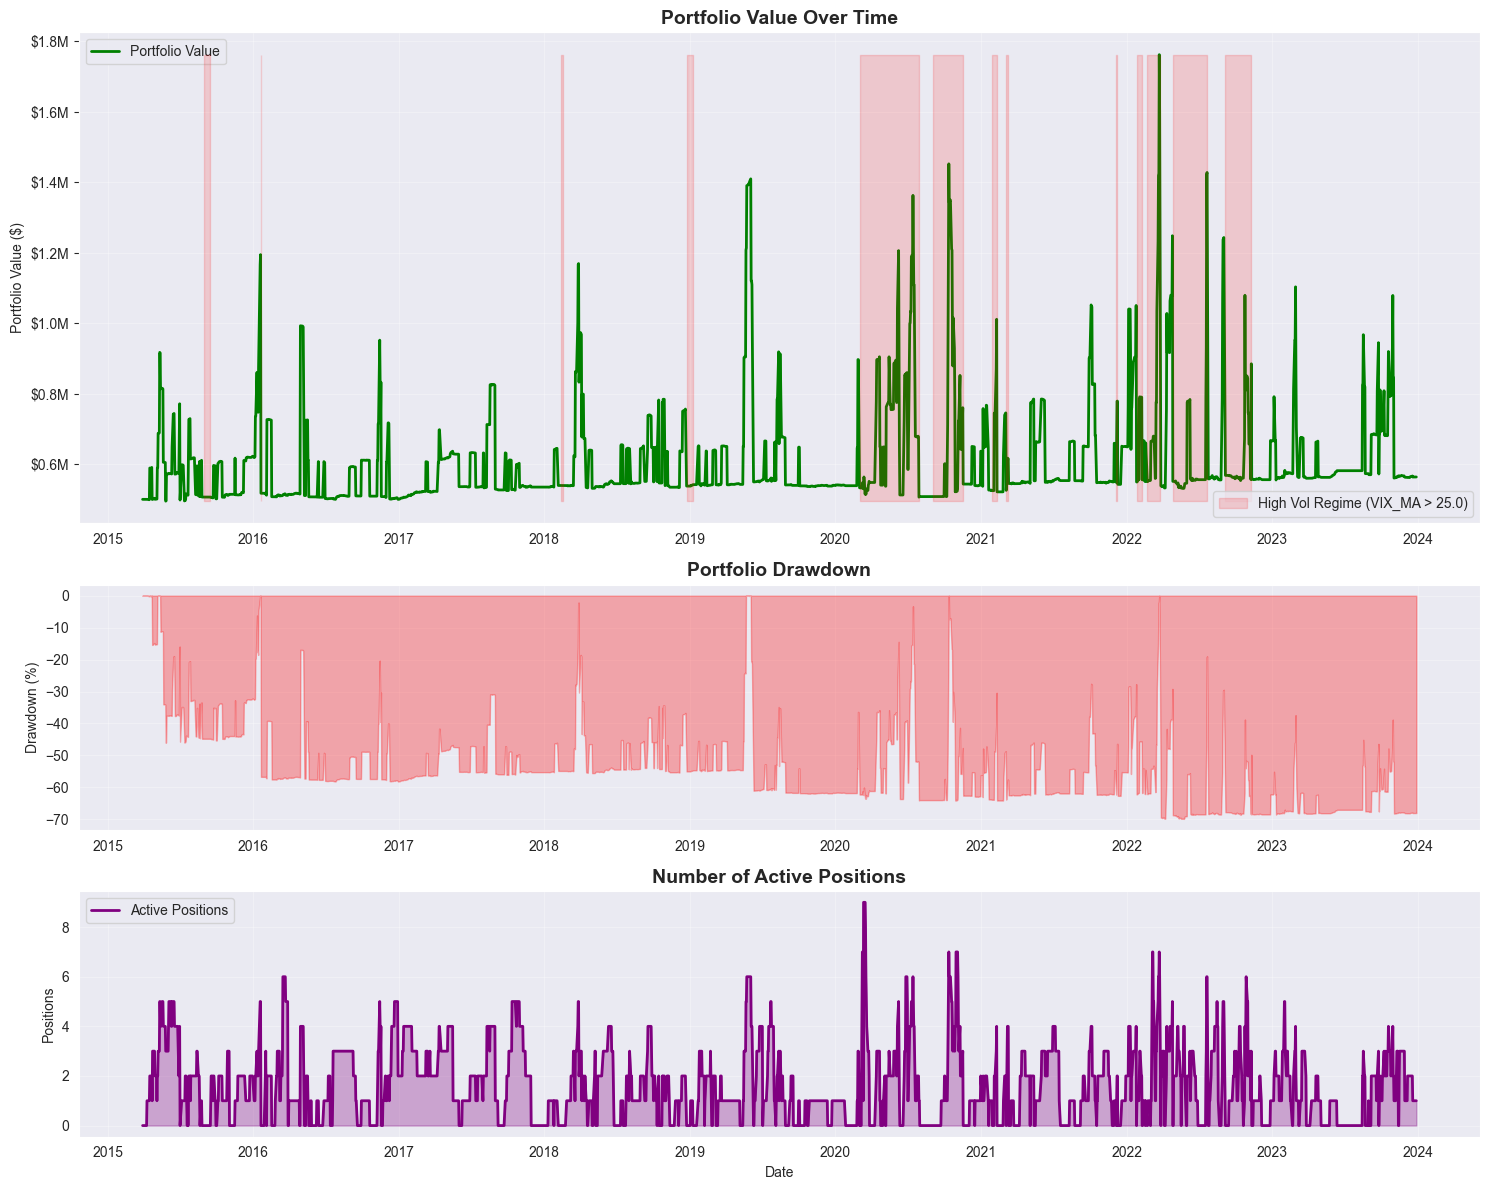


PORTFOLIO PERFORMANCE SUMMARY

Returns:
 Total Return..................      12.70%
 Annualized Return.............       1.38%
 Final Portfolio Value......... $   563,478

Risk Metrics:
 Annualized Volatility.........     154.02%
 Maximum Drawdown..............     -69.88%

Risk-Adjusted Returns:
 Sharpe Ratio..................       0.01
 Sortino Ratio.................       0.01
 Calmar Ratio..................       0.02

Trading Statistics:
 Total Trades..................        527
 Win Rate......................      40.80%
 Profit Factor.................       1.17
 Avg Win Pct...................       5.95%
 Avg Loss Pct..................      -3.08%



CALCULATING BUY-AND-HOLD BENCHMARK

✅ Buy-and-Hold (SPY) calculated
Final Value: $1,359,529.38
Total Return: 171.91%


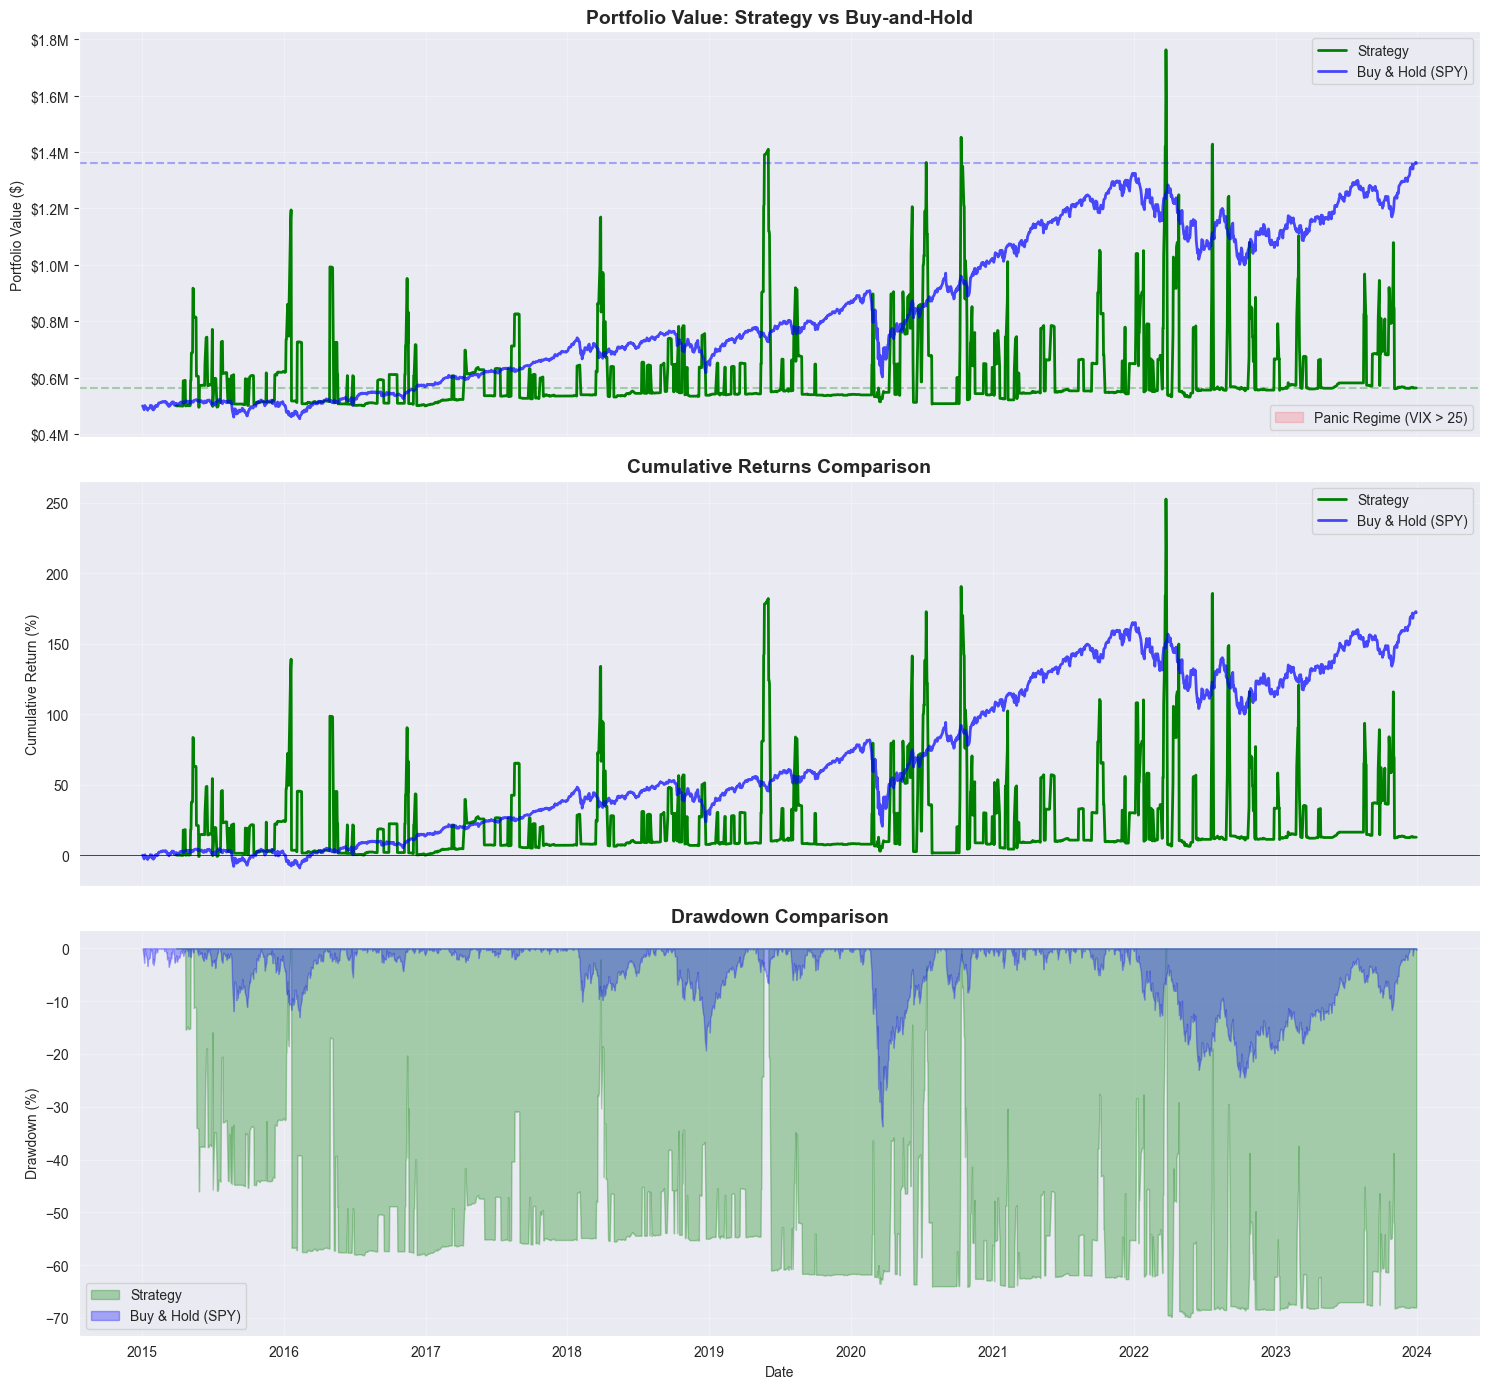


STRATEGY VS BUY-AND-HOLD (SPY) COMPARISON
Period: 2015-01-01 to 2023-12-31

                       Strategy Buy & Hold (SPY) Difference
Total Return             12.70%          171.91%   -159.21%
Annualized Return         1.38%           11.78%    -10.40%
Annualized Volatility   154.02%           18.10%   +135.93%
Sharpe Ratio               0.01             0.65      -0.64
Sortino Ratio              0.01             0.79      -0.78
Max Drawdown            -69.88%          -33.72%    -36.16%
Calmar Ratio               0.02             0.35      -0.33
Final Value            $563,478       $1,359,529  $-796,051




In [54]:
# --- 1. Define Parameters ---
start_date = "2015-01-01"
end_date = "2023-12-31"
stock_list, benchmark, vix_ticker = get_target_stocks()

# Strategy-specific parameters
strategy_params = {
    'initial_capital': 500000.0,
    'transaction_cost': 0.001, # 0.1%
    'leverage': 0.0,
    'max_positions': 10,
    'stop_loss_pct': 0.05,
    'trailing_stop_pct': 0.03,
    'ema_fast': 20,
    'ema_slow': 50,
    'bb_period': 20,
    'bb_std_dev': 2.0
}

# --- 2. Run the Strategy Backtest ---
results = run_backtest(start_date=start_date,
                       end_date=end_date,
                       stock_list=stock_list,
                       **strategy_params)

# --- 3. Run the Benchmark Calculator ---
if results:
    bh_results = calculate_buy_and_hold(benchmark_symbol=benchmark,
                                      start_date=start_date,
                                      end_date=end_date,
                                      initial_capital=strategy_params['initial_capital'])
else:
    print("Strategy backtest failed, skipping benchmark.")
    bh_results = {}

# --- 4. Compare Performance ---
if results and bh_results:
    compare_strategy_vs_benchmark(results['metrics'], 
                                  bh_results,
                                  start_date,
                                  end_date)
else:
    print("Skipping comparison due to missing results.")